**Projeto da disciplina de Data Mining**

**PESC - Programa de Engenharia de Sistemas e Computação**

**COPPE / UFRJ**

Autor: Rafael Lopes Conde dos Reis

E-mail: condereis@cos.ufrj.br 

GitHub: https://github.com/condereis/data-mining

# Resumo

O trabalho consiste em classificar os dados de uma base desconhecida. Nesta planilha existe uma coluna que indica a classe das amostras, algumas das quais são desconhecida, sendo indicadas com "?". A tarefa consiste em realizar a dessas classificação destas amostras, fornecendo como saída seu ID e a respectiva classe. Deverá ser usado o Naive Bayes como baseline e dois (ou mais) classificadores distintos para realizar a mesma tarefa. Por fim, deverá ser feia uma análise dos resultados obtidos.

# Pacotes Utilizados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import lognorm
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

# Análise Exploratória

Primeiramente foi feita uma análise exploratória das variáveis, plotando suas distribuições e um resumo estatístico das mesmas. Pelo resumo estatístico podemos observar que não existe nenhum valor faltando no dataset (exceto os valores que devem ser classificados). É possível notar também que a média e desvio padrão das variáveis X2 a X11 são muito semelhantes entre si e que o a faixa de valores ocupada por essas variáveis é muito estreita, variando em torno de 0,015 do valor máximo ao mínimo. Isso pode dificultar a convergência de alguns algoritmos, sendo indicada uma normalização desses valores.

In [2]:
raw = pd.read_excel('../data/classificacao/classificacao-entrada.xls',
                    decimal=',', index_col=0)
del raw.index.name
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Classe
10,9,1.001079,1.000849,1.000867,1.000638,1.000560,1.000331,1.001636,1.001407,1.001329,1.001099,0.851736,C
11,9,1.001850,1.001681,1.001014,1.000846,1.001014,1.000846,1.002705,1.002537,1.002244,1.002076,3.252083,C
12,9,1.002005,1.001798,1.001753,1.001547,1.001753,1.001547,1.002368,1.002161,1.001753,1.001547,0.653960,C
13,9,1.001509,1.001248,1.001367,1.001107,1.001367,1.001107,1.001674,1.001414,1.001367,1.001107,-0.277188,C
14,9,1.001623,1.001264,1.001135,1.000776,1.000982,1.000622,1.002056,1.001697,1.001596,1.001236,0.859107,C


In [3]:
raw.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000
mean,13.004262,1.000001,1.000001,0.999999,0.999999,0.999690,0.999689,1.000314,1.000314,0.999999,0.999999,-0.000342
std,2.581256,0.000739,0.000653,0.000663,0.000568,0.000740,0.000654,0.000735,0.000650,0.000787,0.000708,1.000223
min,9.000000,0.993092,0.993643,0.993583,0.993711,0.992300,0.992941,0.994045,0.994172,0.992452,0.993354,-1.062153
25%,11.000000,0.999619,0.999661,0.999677,0.999721,0.999347,0.999392,0.999911,0.999948,0.999608,0.999649,-0.673970
50%,13.000000,1.000002,0.999999,1.000001,0.999998,0.999752,0.999750,1.000248,1.000242,0.999999,1.000000,-0.295615
75%,15.000000,1.000395,1.000342,1.000338,1.000283,1.000097,1.000051,1.000661,1.000616,1.000394,1.000356,0.351766
max,18.000000,1.007497,1.007155,1.006971,1.006781,1.006844,1.006781,1.008614,1.008299,1.007755,1.007692,14.230537


In [4]:
raw_train = raw[raw.Classe != '?']
raw_test = raw[raw.Classe == '?'].drop(['Classe'], axis=1)

## Distribuições das Variáveis

O plot abaixo, mostra a relação de cada par de variáveis, assim como um histograma de cada uma, separando cada classe com uma cor. Observando as distribuição das variáveis é possível notar claramente que a variável X1 é categórica e aprezenda distribuições consideravelmente distintas para cada classe. As demais variáveis, exceto X12, apresentam forte correlação linear entre sí, além de possuírem uma distribuição que se assemelha a uma gaussiana. A variável X12, já não apresenta uma correlação linear forte com as demais e sua distribuição se assemelha mais a uma distribuição exponencial ou lognormal.  

Não é possível ver nenhuma forma de agrupamento das diferentes classe a olho nú por meio do plot abaixo (exceto em X1). É possível que aplicar uma redução de dimensão, uma vez que há uma forte correlação entre muitas das dimensões possa vir a permitir uma melhor visualização de agrupamentos por classe.

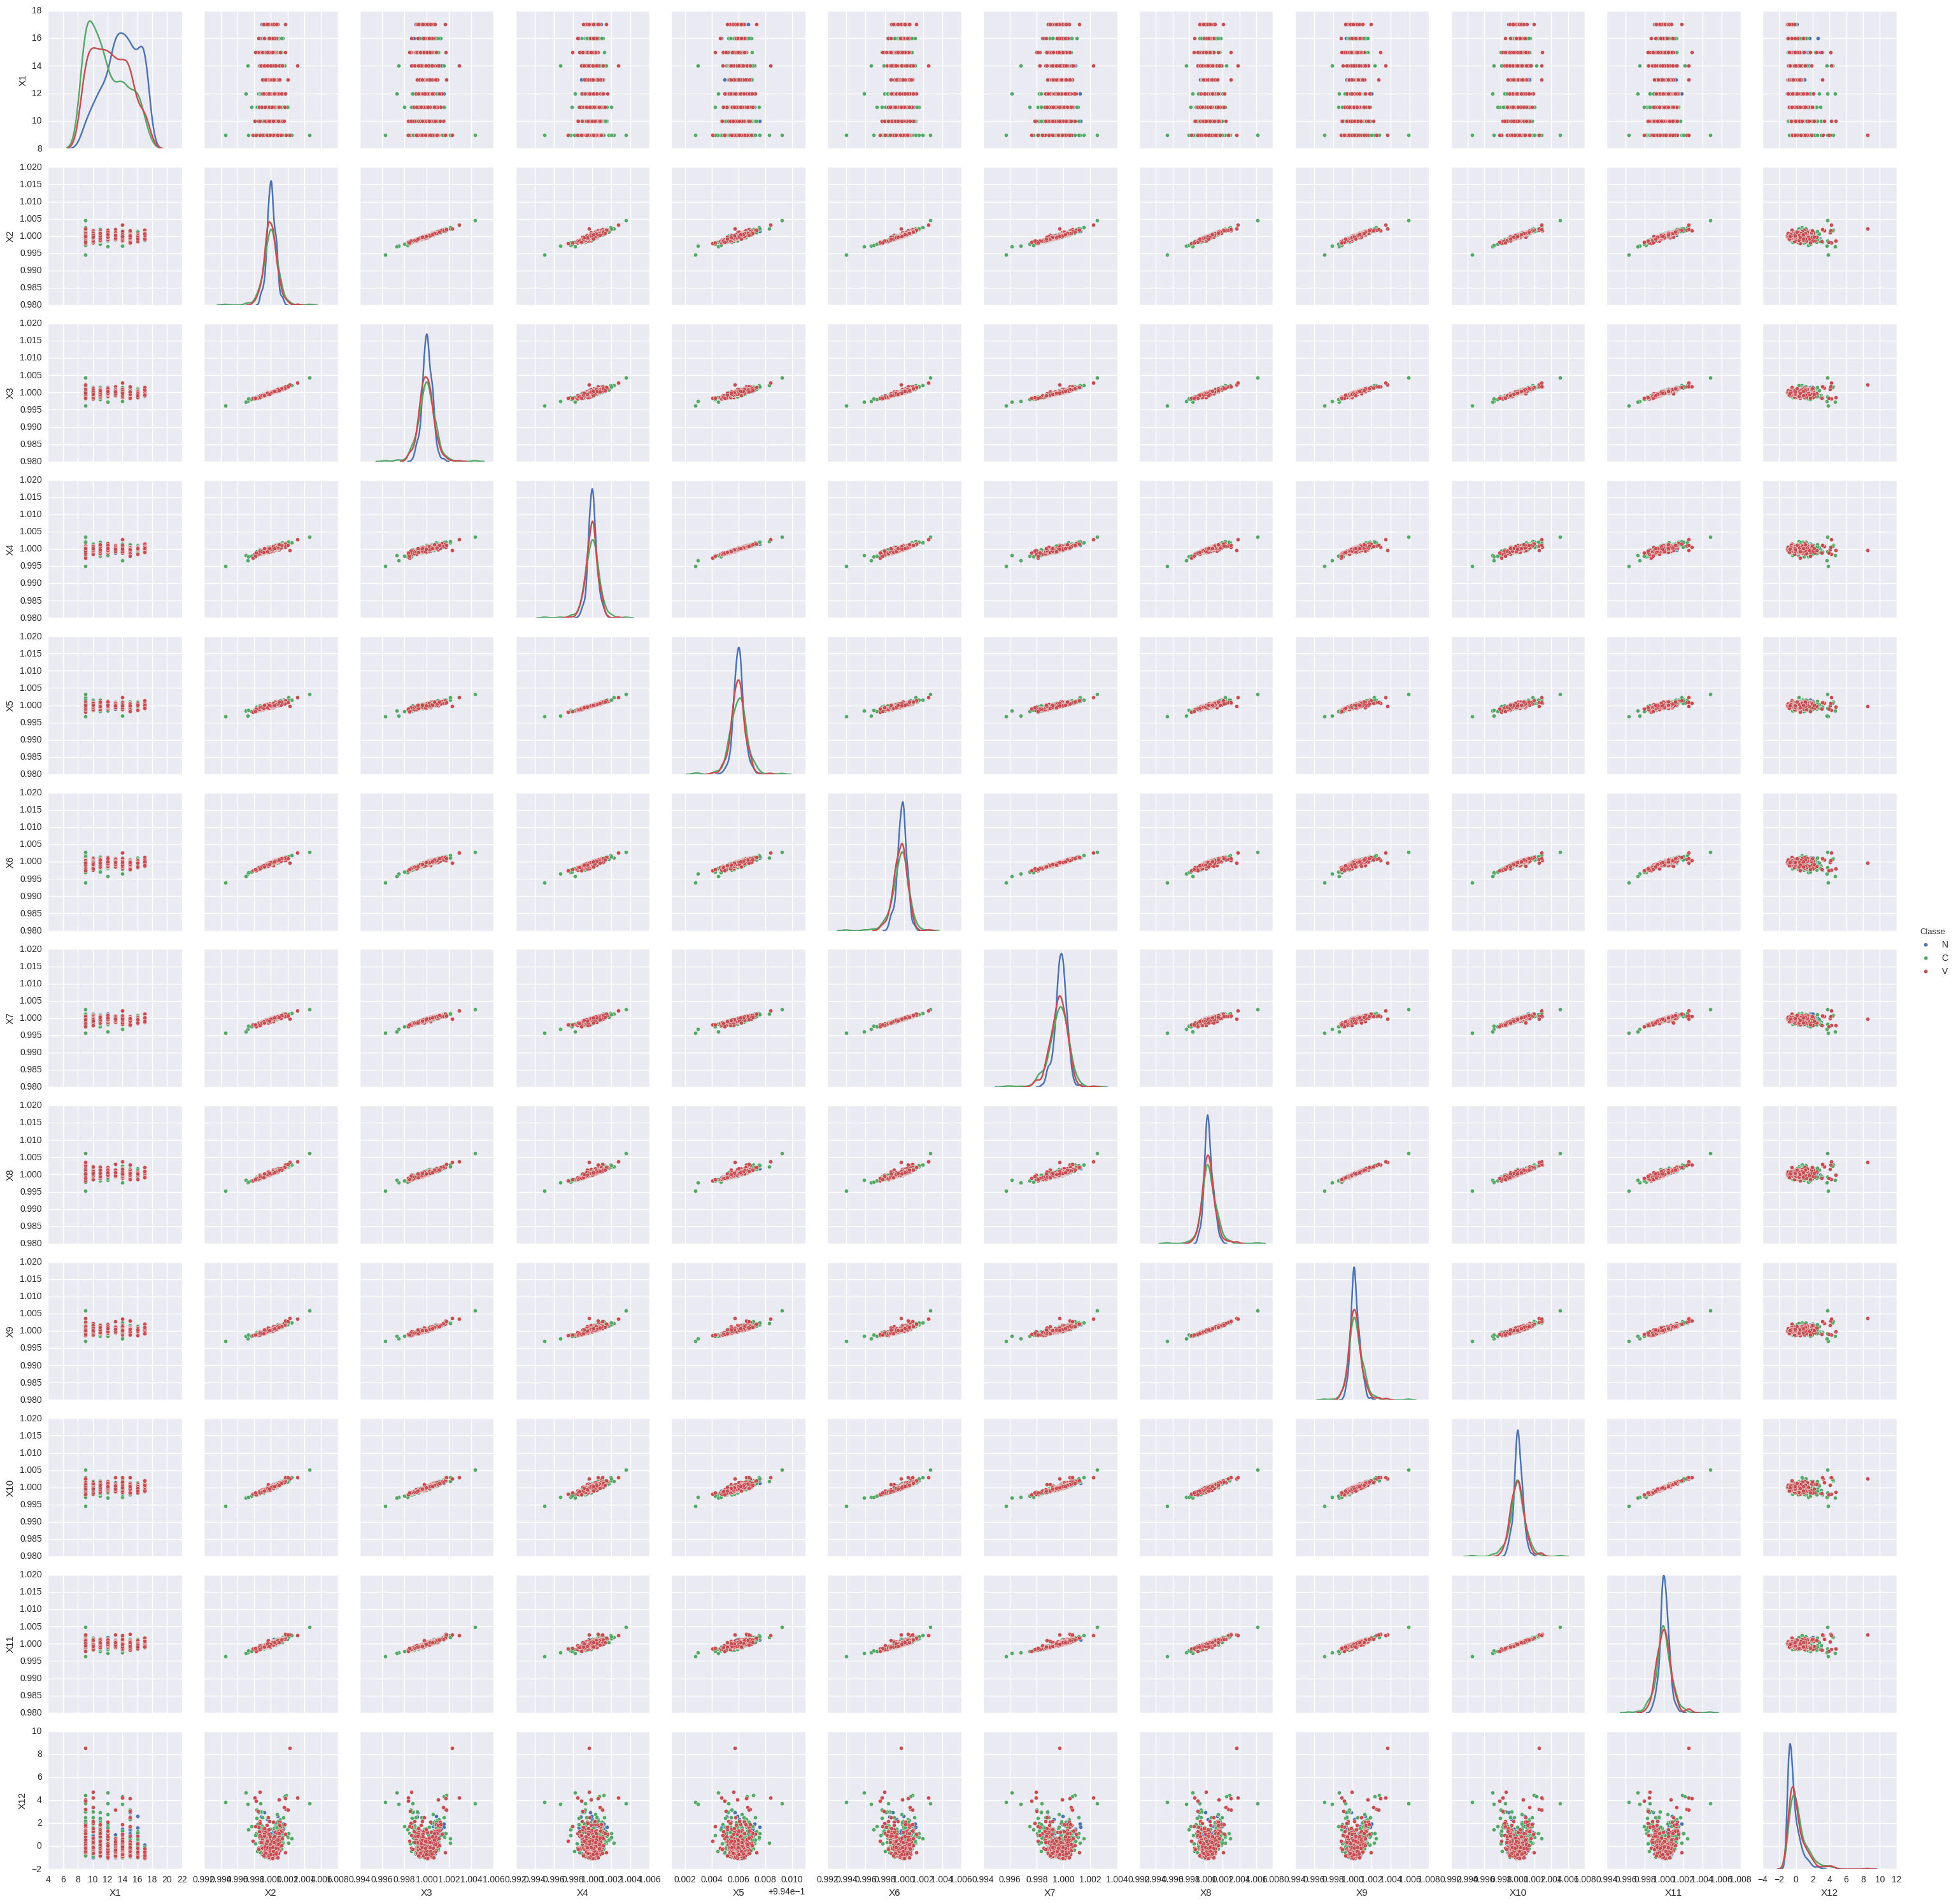

In [5]:
sns.pairplot(raw_train.sample(frac=0.1), diag_kind=b"kde", hue='Classe');

Exibindo em detalhe a distribuição de probabilidade da variável X1 para cada classe pode-se observar que a classe N está bastante separada das demais. 

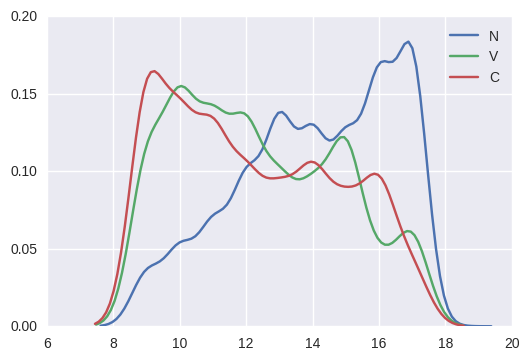

In [48]:
sns.kdeplot(raw_train[raw_train.Classe == 'N']['X1'], label='N')
sns.kdeplot(raw_train[raw_train.Classe == 'V']['X1'], label='V')
sns.kdeplot(raw_train[raw_train.Classe == 'C']['X1'], label='C')

### Redução de Dimensionalidade
Ao testar a aplicação de PCA, reduzindo para 2 e 3 componentes principais, nas variáveis fortemente correlacionadas podemos observar que continua não havendo grupos bem separados dos dados.

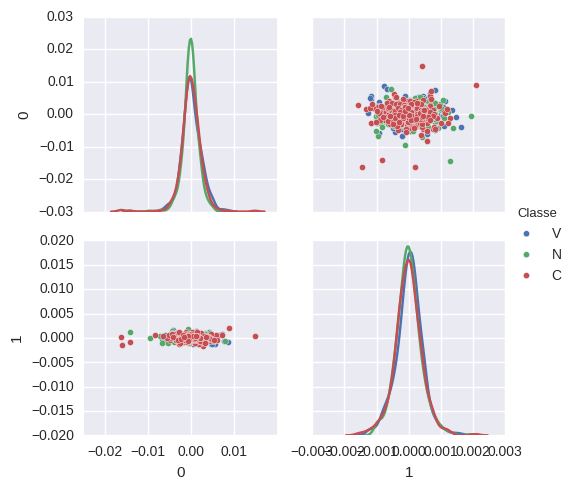

In [6]:
reduced_data = PCA(n_components=2).fit_transform(
    raw_train.drop(['X1','X12','Classe'], axis=1)
)
pca_data = pd.concat([raw_train['Classe'], pd.DataFrame(reduced_data)],
                     axis=1, join='inner')
sns.pairplot(pca_data.sample(frac=0.2), diag_kind="kde", hue='Classe');

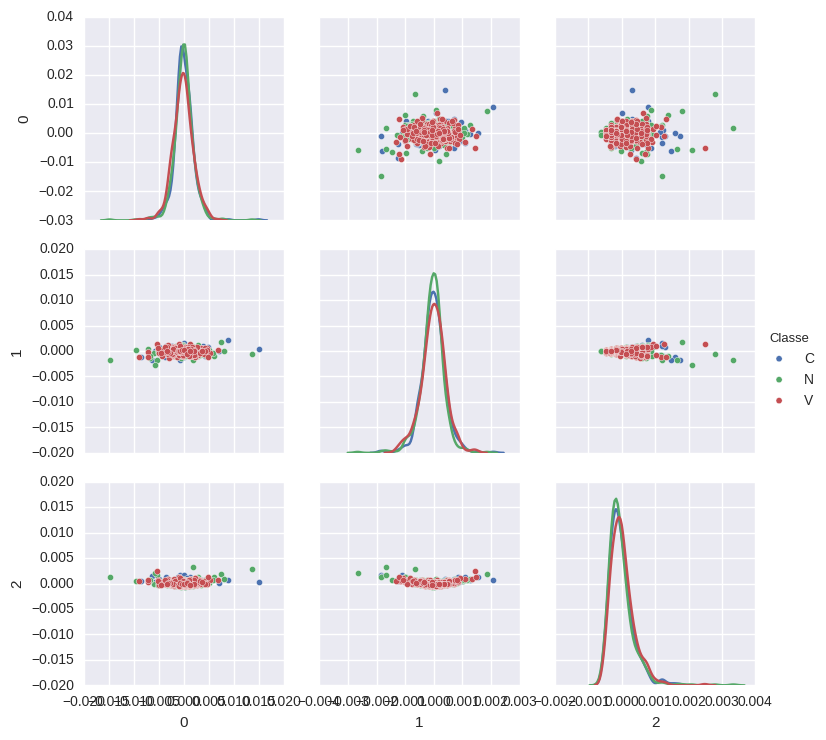

In [7]:
reduced_data = PCA(n_components=3).fit_transform(
    raw_train.drop(['X1','X12','Classe'], axis=1)
)
pca_data = pd.concat([raw_train['Classe'], pd.DataFrame(reduced_data)],
                     axis=1, join='inner')
sns.pairplot(pca_data.sample(frac=0.2), diag_kind="kde", hue='Classe');

Por último é possível observar que as classes são bem balanceadas, o que é positivo uma vez que muitos modelos não funcionam bem com problemas onde existe uma variância muito grande entre as classes. Esse fato faz com que não seja necessário o uso de uma medida de eficiência mais sofisticada, como a área sob a curva ROC, e portando foi analisada a acurácia na classificação como medida de eficiência.

Também é possível setar um primeiro baseline de acurácia. A acurácia ao chutar a classe mais frequente é de 0.386981.

Acurácia ao chutar a classe mais frequente: 0.386981


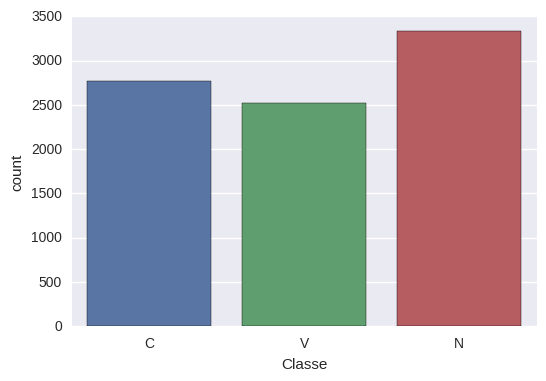

In [8]:
sns.countplot(x="Classe", data=raw_train);
print 'Acurácia ao chutar a classe mais frequente: %f' % (
    len(raw_train[raw_train.Classe == 'N'])/float(len(raw_train))
)

# Pré-processamento

## Variável X1

Como é possível observar na figura abaixo a variável X1 é categórica. Suas classes tem distribuição praticamente homogênea, com exceção da classe 18 que praticamente não tem representatividade quando comparada com as demais.

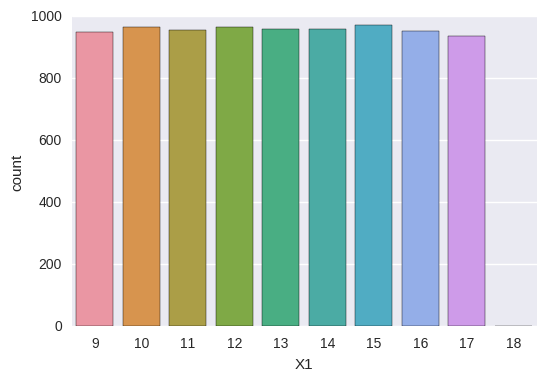

In [9]:
sns.countplot(x="X1", data=raw_train);

Como a variável X1 é categórica ela sera codificada por *one hot encoding*, ou seja, cada valor se transforma num array onde apenas o elemento com o índice igual a classe é 1 e os demais são 0. Como a classe 18 tem baixa representatividade ela será removida do vetor, de forma que a informação de pertencer a classe 18 será codificada por um vetor de zeros.

In [10]:
x1_preproc = pd.get_dummies(raw['X1'], prefix='X1').drop(['X1_18'],
                                                         axis=1)
x1_preproc.head()

,X1_9,X1_10,X1_11,X1_12,X1_13,X1_14,X1_15,X1_16,X1_17
10,1,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0
13,1,0,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0,0


## Variável X12
O plot abaixo mostra a distribuição da variável X12. Como foi falado, se aproxima muito de uma distribuição lognormal. O único problema é que ela parece estar deslocada para a esquerda e uma distribuição lognormal não pode conter valores negativos. A figura abaixo mostra a distribuição ao ser somado 2 como offset. Esse valor possui uma margem considerável do menor valor encontrado (-1.062153). 

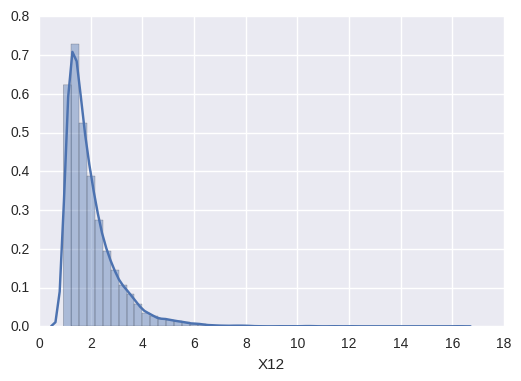

In [11]:
sns.distplot(raw['X12']+2)

Foram então calculadas a média e a variância da suposta distribuição lognormal por meio da *maximum likelihood estimation*. Foi subtraída a média e dividida pela variância. Por fim calculou-se o logaritmo neperiano da distribuição a fim de encontrar uma distribuição normal com média próxima a 0 e variância aproximadamente unitária.  A figura abaixo mostra a nova distribuição. Esta parece ser uma boa maneira de pré-processar a variável X12.

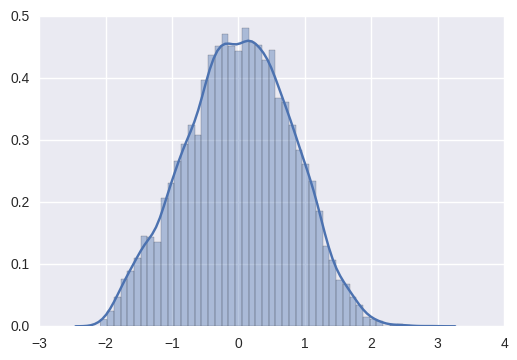

In [12]:
param = lognorm.fit(raw['X12']+2)
x12_preproc = np.log((raw['X12']+2-param[0])/param[1]).to_frame()
sns.distplot(x12_preproc)

## Variáveis X2 a X11

Elas serão apenas processadas para terem média 0 e variância unitária.

In [13]:
x2_x11 = raw[['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
              'X11']]
x2_x11_preproc = (x2_x11 - x2_x11.mean())/x2_x11.std()
x2_x11_preproc.head()

,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
10,1.457189,1.299660,1.308473,1.123997,1.175316,0.979785,1.798238,1.682393,1.689945,1.554725
11,2.499964,2.574294,1.529997,1.490015,1.789300,1.767710,3.252396,3.422107,2.853775,2.934645
12,2.709811,2.753005,2.644556,2.722678,2.788089,2.838679,2.794082,2.844237,2.230230,2.187292
13,2.038886,1.911088,2.061518,1.948194,2.265612,2.165787,1.849781,1.693174,1.738525,1.565085
14,2.193663,1.934487,1.712309,1.366518,1.745235,1.425817,2.370006,2.129113,2.029687,1.748551


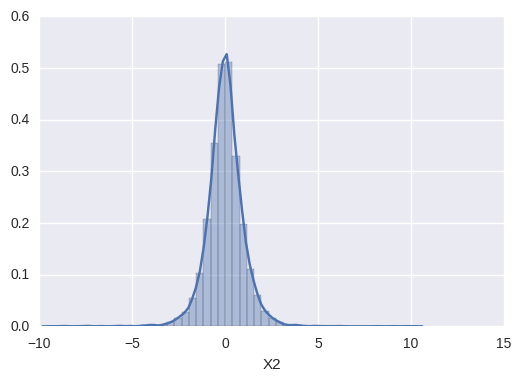

In [14]:
sns.distplot(x2_x11_preproc['X2'])

Finalmente, os dados são concatenados a coluna Classe e separados em treino e teste.

In [15]:
preproc = pd.concat([x1_preproc, x2_x11_preproc, x12_preproc, raw['Classe']],
                    axis=1, join='inner')
preproc.head()

,X1_9,X1_10,X1_11,X1_12,X1_13,X1_14,X1_15,X1_16,X1_17,X2,...,X4,X5,X6,X7,X8,X9,X10,X11,X12,Classe
10,1,0,0,0,0,0,0,0,0,1.457189,...,1.308473,1.123997,1.175316,0.979785,1.798238,1.682393,1.689945,1.554725,0.859321,C
11,1,0,0,0,0,0,0,0,0,2.499964,...,1.529997,1.490015,1.789300,1.767710,3.252396,3.422107,2.853775,2.934645,1.642169,C
12,1,0,0,0,0,0,0,0,0,2.709811,...,2.644556,2.722678,2.788089,2.838679,2.794082,2.844237,2.230230,2.187292,0.756335,C
13,1,0,0,0,0,0,0,0,0,2.038886,...,2.061518,1.948194,2.265612,2.165787,1.849781,1.693174,1.738525,1.565085,0.041533,C
14,1,0,0,0,0,0,0,0,0,2.193663,...,1.712309,1.366518,1.745235,1.425817,2.370006,2.129113,2.029687,1.748551,0.862961,C


In [16]:
train = preproc[preproc.Classe != '?']
test = preproc[preproc.Classe == '?'].drop(['Classe'], axis=1)

# Naive Bayes

Primeiramente foi testado Naive Bayes com os dados antes e após o pré-processamento, concluindo que de fato o pré-processamento foi positivo para o modelo, aumentando a acurácia em mais de 10 pontos percentuais. Em seguida aplicado redução de dimensionalidade com PCA e avaliar o desempenho do modelo conforme o número de dimensões é reduzido.

In [17]:
model = GaussianNB()
train_raw = raw[raw.Classe != '?']
scores = cross_val_score(model, train_raw.drop('Classe', axis=1),
                         train_raw['Classe'], cv=5, n_jobs=-1)
print 'Naive Bayes sem Pré-processamento: %f +- %f' % (
    np.mean(scores),np.std(scores))
model = GaussianNB()
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'Naive Bayes com Pré-processamento: %f +- %f' % (
    np.mean(scores), np.std(scores))
best_nb = model.fit(train.drop('Classe', axis=1), train['Classe'])

Naive Bayes sem Pré-processamento: 0.447430 +- 0.027280
Naive Bayes com Pré-processamento: 0.480382 +- 0.028656


A sequir é plotada a matriz de confusão do modelo. Por ela é possível observar que o modelo, para a classe N, possui uma taxa de acerto muito maior do que para as demais. Isso confirma o que foi visto na distribuição da variável X1.

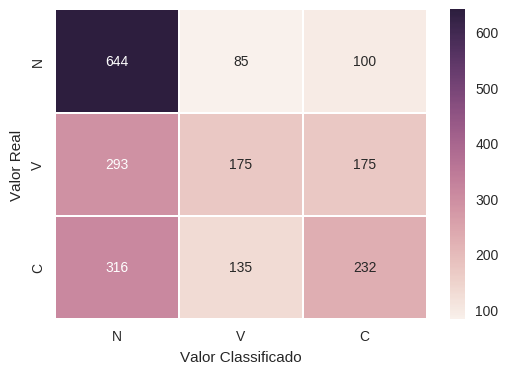

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Classe', axis=1),  train['Classe'], random_state=0)
model = GaussianNB()
y_pred = model.fit(X_train,y_train).predict(X_test)
labels = ['N', 'V', 'C']
mtx = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(pd.DataFrame(mtx, columns=labels, index=labels), annot=True, fmt="d", linewidths=.5)
plt.xlabel('Valor Classificado')
plt.ylabel('Valor Real')

# Logistic Regression

O segundo modelo aplicado foi Logistic Regression. Usando as configurações padrões o resultado foi inferior ao obtido com Naive Bayes. A seguir, porém, foi feito um ajuste fino no modelo.

In [19]:
model = LogisticRegression()
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'Logistic Regression: %f +- %f' % (np.mean(scores), np.std(scores))

Logistic Regression: 0.476784 +- 0.026070


Aplicando redução de dimensionalidade a acurácia obtida teve seu valor médio máximo com PCA reduzindo para 13 dimensões. 

<Container object of 3 artists>

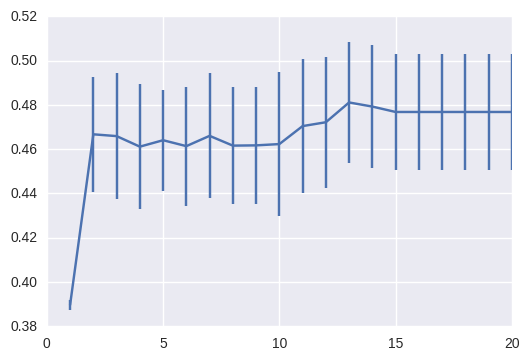

In [20]:
score_list = []
error_list = []
n_dims = range(1,train.shape[1])
model = LogisticRegression()
for dim in n_dims:
    reduced_data = PCA(n_components=dim).fit_transform(
        train.drop('Classe', axis=1)
    )
    scores = cross_val_score(model, reduced_data, train['Classe'], cv=5,
                             n_jobs=-1)
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(n_dims, score_list, yerr=error_list)

Por fim foi variado o parâmetro C, que corresponde a inversa da força de regularização. Foram testados valores variando entre 0.0001 a 10000. A melhor configuração foi a com C=10. O valor encontrado para a acurácia na melhor configuração foi de 0.481541 +- 0.027655.

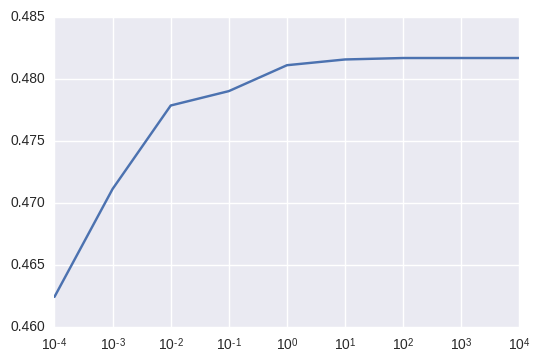

In [21]:
reduced_data = PCA(n_components=13).fit_transform(
        train.drop('Classe', axis=1)
    )
clf = LogisticRegression()
c_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
param_dist = {"C": c_list}
# run randomized search
grid_search = GridSearchCV(clf, param_grid=param_dist, cv=5, n_jobs=-1)
grid_search.fit(reduced_data, train['Classe'])
plt.plot(c_list, grid_search.cv_results_['mean_test_score'])
plt.xscale('log')

In [22]:
model = LogisticRegression(C=10)
scores = cross_val_score(model, reduced_data, train['Classe'],
                         cv=5, n_jobs=-1)
print 'Best Logistic Regression: %f +- %f' % (
    np.mean(scores), np.std(scores))
best_lr = model.fit(reduced_data, train['Classe'])

Best Logistic Regression: 0.481541 +- 0.027655


Como esperado pela pequena variação na acurácia, não houve variação significativa na matriz de confusão.

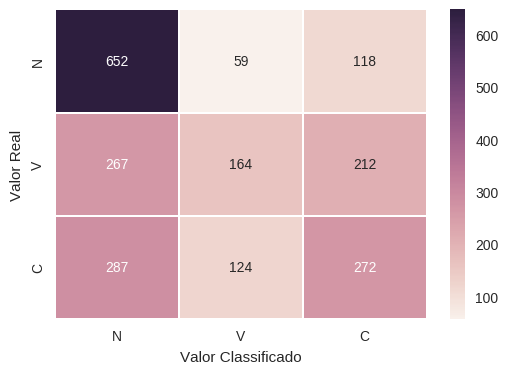

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Classe', axis=1),  train['Classe'], random_state=0)
model = LogisticRegression(C=10)
y_pred = model.fit(X_train,y_train).predict(X_test)
labels = ['N', 'V', 'C']
mtx = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(pd.DataFrame(mtx, columns=labels, index=labels), annot=True, fmt="d", linewidths=.5)
plt.xlabel('Valor Classificado')
plt.ylabel('Valor Real')

# Support Vector Machine

O primeiro passo para a aplicação de SVM foi definir qual o tipo de kernel que seria usado. Para isso foram testados 4 tipos: Linear, polinomial, sigmoidal e RBF. Para cada teste foi usada 5-fold cross-validation. 
Surpreendentemente o kernel liner foi superior ao polinomial, porem o RBF foi o que apresentou melhor desempenho entre os 4.

In [24]:
model = svm.SVC(kernel='linear')
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'SVM - Linear: %f +- %f' % (np.mean(scores), np.std(scores))
model = svm.SVC(kernel='poly')
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'SVM - Polinomial: %f +- %f' % (np.mean(scores), np.std(scores))
model = svm.SVC(kernel='sigmoid')
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'SVM - Sigmoidal: %f +- %f' % (np.mean(scores), np.std(scores))
model = svm.SVC()
scores = cross_val_score(model, train.drop('Classe', axis=1),
                         train['Classe'], cv=5, n_jobs=-1)
print 'SVM - RBF: %f +- %f' % (np.mean(scores), np.std(scores))

SVM - Linear: 0.455894 +- 0.029928
SVM - Polinomial: 0.437453 +- 0.020423
SVM - Sigmoidal: 0.372704 +- 0.018569
SVM - RBF: 0.479916 +- 0.027878


Aplicando redução de dimensionalidade a acurácia obtida teve seu valor médio máximo com PCA reduzindo para 13 dimensões. 

<Container object of 3 artists>

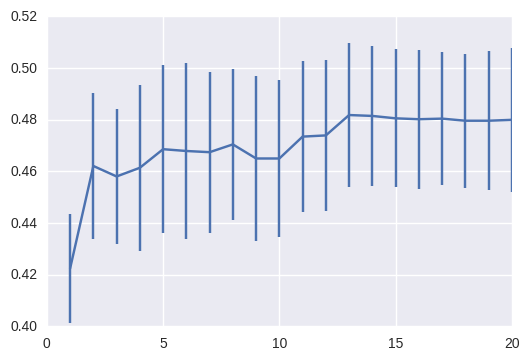

In [25]:
score_list = []
error_list = []
n_dims = range(1,train.shape[1])
model = svm.SVC()
for dim in n_dims:
    reduced_data = PCA(n_components=dim).fit_transform(
        train.drop('Classe', axis=1)
    )
    scores = cross_val_score(model, reduced_data, train['Classe'],
                             cv=5, n_jobs=-1)
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(n_dims, score_list, yerr=error_list)

Por fim foram variados os parâmetros C (parâmetro de penalidade do erro) e *gamma* (o coeficiente do kernel) do modelo. Foram testados valores variando entre 0.01 a 100 para C e entre 0.02 e 0.5 para *gama*. A melhor configuração foi a com C=10 e *gamma*=0.05. O valor encontrado para a acurácia na melhor configuração foi de 0.484209 +- 0.028707.

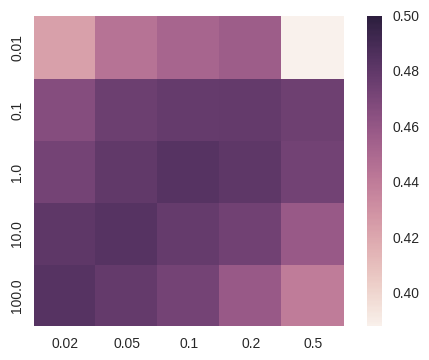

In [32]:
reduced_data = PCA(n_components=13).fit_transform(
        train.drop('Classe', axis=1)
    )
clf = svm.SVC()
c_list = [0.01, 0.1, 1, 10, 100]
gamma_list = [0.02, 0.05, 0.1, 0.2, 0.5]
param_dist = {
    "C": c_list,
    "gamma": gamma_list
}
# run randomized search
grid_search = GridSearchCV(clf, param_grid=param_dist, cv=5,
                           n_jobs=-1)
grid_search.fit(reduced_data, train['Classe'])

mtx = grid_search.cv_results_['mean_test_score'].reshape(5,5)
sns.heatmap(pd.DataFrame(mtx, columns=gamma_list, index=c_list),
            vmax=.5,
            square=True)

In [33]:
model = grid_search.best_estimator_
scores = cross_val_score(model, reduced_data, train['Classe'],
                         cv=5, n_jobs=-1)
print 'SVM: %f +- %f' % (np.mean(scores), np.std(scores))
best_svm = model.fit(reduced_data, train['Classe'])

SVM: 0.484209 +- 0.028707


Novamente, como esperado pela pequena variação na acurácia, não houve variação significativa na matriz de confusão.

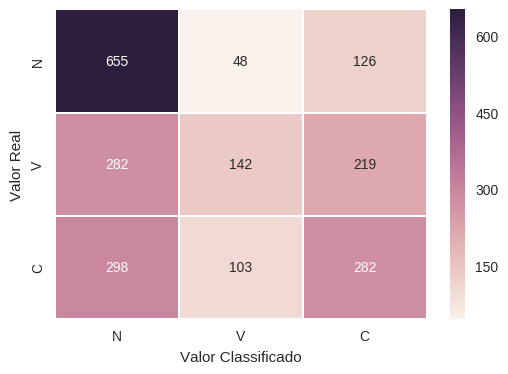

In [36]:
reduced_data = PCA(n_components=13).fit_transform(
        train.drop('Classe', axis=1)
    )
X_train, X_test, y_train, y_test = train_test_split(reduced_data,  train['Classe'], random_state=0)
model = grid_search.best_estimator_
y_pred = model.fit(X_train,y_train).predict(X_test)
labels = ['N', 'V', 'C']
mtx = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(pd.DataFrame(mtx, columns=labels, index=labels), annot=True, fmt="d", linewidths=.5)
plt.xlabel('Valor Classificado')
plt.ylabel('Valor Real')

# Conclusão

Os modelos testados apresentaram resultados muito semelhantes para os dados utilizados, mesmo após terem seus parâmetros ajustados. O modelo SVM foi o que apresentou o maior resultado, porém a diferença é tão pequena comparada com a margem de erro que não justifica seu uso. O modelo Naive Bayes teve um resultado tão bom quanto e é um modelo de interpretação muito mais simples, portanto esta seria a escolha de modelo, dentre os testados.

# Aplicação dos modelos nos dados não classificados

In [37]:
reduced_data = PCA(n_components=13).fit_transform(test)

predict = best_nb.predict(test)
out_df = pd.DataFrame(predict, columns=['Classe'], index=test.index)
out_df.to_csv('../data/classificacao/out_naive_bayes.csv')

predict = best_lr.predict(reduced_data)
out_df = pd.DataFrame(predict, columns=['Classe'], index=test.index)
out_df.to_csv('../data/classificacao/out_logistic_regression.csv')

predict = best_svm.predict(reduced_data)
out_df = pd.DataFrame(predict, columns=['Classe'], index=test.index)
out_df.to_csv('../data/classificacao/out_svm.csv')